# Cuaderno 02: Entrenamiento de Expertos (Versión Refactorizada y Definitiva)

### Objetivo 🎯
Este cuaderno implementa un flujo de trabajo **limpio, simplificado y robusto** para entrenar y validar nuestros dos clasificadores expertos. El objetivo es crear "jueces" neuronales infalibles que servirán como `ground-truth` para la pérdida perceptual en los cuadernos posteriores.

### Lógica de Entrenamiento y Validación (Corregida)

1.  **Entrenamiento sobre el 100% de los Datos**: Para cada experto (fonemas y palabras), entrenamos el modelo utilizando el **conjunto completo de datos disponibles**. No hay un conjunto de validación separado.
2.  **Evaluación sobre el 100% de los Datos**: Al final de cada época, evaluamos el rendimiento del modelo sobre ese mismo 100% de los datos.

El objetivo de esta metodología no es medir la capacidad de generalización, sino confirmar que la arquitectura del modelo (`SequentialClassifierLSTM`) es lo suficientemente potente como para **aprender a separar perfectamente las clases** cuando ha visto todos los ejemplos. Una precisión de validación cercana al 100% nos da la máxima confianza en que nuestros "jueces" son fiables.

### Artefactos Generados

Para cada experto (fonemas y palabras), este cuaderno genera y guarda sistemáticamente:
-   📈 **Curvas de Aprendizaje** (`.png`)
-   🎨 **Gráfico t-SNE** (`.png`) para visualizar la separabilidad de las clases.
-   🧩 **Matriz de Confusión y Heatmap de Logits** (`.png`, solo para fonemas).
-   📊 **Reporte de Clasificación** (`.csv`) con métricas detalladas.
-   💾 **Modelo Final y Mapeo de Etiquetas** (`.pth`), listo para ser importado en los siguientes cuadernos.


In [1]:
# ===================================================================
# Celda 2: Configuración e Instalación
# ===================================================================
%pip install torch scikit-learn seaborn pandas matplotlib --quiet

import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torch.nn.utils.rnn import pad_sequence
from pathlib import Path
import numpy as np, pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import glob, warnings

# Suprimir advertencias de sklearn para mayor claridad en la salida
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn')

Note: you may need to restart the kernel to use updated packages.


In [2]:
# ===================================================================
# Celda 3: Parámetros Globales y Rutas
# ===================================================================
LANGUAGES = ['es', 'en']
MODEL_ARCHITECTURE = "expert_classifier_final"
EPOCHS = 250  # Suficiente para que converja en el dataset completo
BATCH_SIZE = 32
LEARNING_RATE = 0.0005
RANDOM_SEED = 42

# Hiperparámetros del Modelo LSTM (usando la dimensión correcta de 1024)
EMBED_DIM = 1024
LSTM_HIDDEN_DIM = 256
LSTM_N_LAYERS = 2
LSTM_DROPOUT = 0.4

# Rutas del Proyecto
project_root = Path.cwd().parent
dictionaries_dir = project_root/"data/01_raw/dictionaries"
phoneme_embedding_dir_base = project_root/"data/02_processed/wav2vec2_embeddings"
word_embedding_dir_base = project_root/"data/02_processed/word_embeddings"
model_dir = project_root/"results/trained_models"
figure_dir = project_root/"results/figures"
results_dir = project_root/"results/tables"
for path in [model_dir, figure_dir, results_dir]: path.mkdir(parents=True, exist_ok=True)

# Configuración de Semillas
torch.manual_seed(RANDOM_SEED); np.random.seed(RANDOM_SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# ===================================================================
# Celda 4: Definición de Clases y Funciones de Apoyo
# ===================================================================
class SequentialEmbeddingDataset(Dataset):
    def __init__(self, embedding_dir, expected_dim):
        self.embedding_files = sorted(glob.glob(str(embedding_dir / '*.npy')))
        self.labels_text = sorted([Path(f).stem for f in self.embedding_files])
        self.label_to_int = {label: i for i, label in enumerate(self.labels_text)}
        self.int_to_label = {i: label for i, label in enumerate(self.labels_text)}
        self.expected_dim = expected_dim
    def __len__(self): return len(self.embedding_files)
    def __getitem__(self, idx):
        file_path = self.embedding_files[idx]
        sequence = np.load(file_path)
        # Verificación de seguridad
        if sequence.ndim < 2 or sequence.shape[0] == 0: return None # Ignorar archivos vacíos o corruptos
        if sequence.shape[-1] != self.expected_dim: raise ValueError(f"Dimensión incorrecta en '{Path(file_path).name}'")
        return torch.tensor(sequence, dtype=torch.float32), torch.tensor(self.label_to_int[Path(file_path).stem], dtype=torch.long)

def collate_fn_sequential(batch):
    # Filtrar cualquier item que sea None
    batch = [item for item in batch if item is not None]
    if not batch: return None, None, None
    sequences, labels = zip(*batch)
    lengths = torch.tensor([len(seq) for seq in sequences])
    padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=0.0)
    return padded_sequences, lengths, torch.stack(labels)

class SequentialClassifierLSTM(nn.Module):
    def __init__(self, embed_dim, num_classes, hidden_dim, n_layers, dropout):
        super().__init__(); self.lstm = nn.LSTM(input_size=embed_dim, hidden_size=hidden_dim, num_layers=n_layers, batch_first=True, dropout=dropout if n_layers > 1 else 0, bidirectional=True); self.classifier_head = nn.Linear(hidden_dim * 2, num_classes)
    def forward(self, x_padded, x_lengths):
        packed_input = nn.utils.rnn.pack_padded_sequence(x_padded, x_lengths.cpu(), batch_first=True, enforce_sorted=False); _, (hidden, _) = self.lstm(packed_input); hidden_concat = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1); return self.classifier_head(hidden_concat)

def plot_learning_curves(history, title, file_path):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    ax1.plot(history['train_loss'], label='Train Loss', color='darkred')
    ax1.plot(history['val_loss'], label='Validation Loss', color='lightcoral')
    ax1.set_title('Pérdida del Modelo'); ax1.set_xlabel('Epochs'); ax1.set_ylabel('Loss'); ax1.legend(); ax1.grid(True)
    ax2.plot(history['val_acc'], label='Validation Accuracy', color='darkgreen')
    ax2.set_title('Precisión del Modelo'); ax2.set_xlabel('Epochs'); ax2.set_ylabel('Accuracy'); ax2.legend(); ax2.grid(True)
    fig.suptitle(title, fontsize=16); plt.savefig(file_path); plt.show()

In [4]:
# ===================================================================
# Celda 5: Bucle Principal de Entrenamiento y Evaluación
# ===================================================================
results_all = {}
for lang in LANGUAGES:
    for expert_type in ["phoneme", "word"]:
        print(f"=====================================================\nProcesando Experto en {expert_type.capitalize()}s para: {lang.upper()}\n=====================================================")
        
        # --- 1. Cargar Datos ---
        if expert_type == "phoneme":
            embedding_dir = phoneme_embedding_dir_base / lang
            full_dataset = SequentialEmbeddingDataset(embedding_dir, expected_dim=EMBED_DIM)
        else: # expert_type == "word"
            embedding_dir = word_embedding_dir_base / lang
            dict_path = dictionaries_dir / f"{lang}_words.txt"
            with open(dict_path, 'r', encoding='utf-8') as f: word_list = [line.strip() for line in f if line.strip()]
            full_dataset = SequentialEmbeddingDataset(embedding_dir, expected_dim=EMBED_DIM)
            files_to_keep = {str(embedding_dir / f"{w}.npy") for w in word_list}
            # Filtramos los archivos del dataset para quedarnos solo con los de nuestro diccionario
            full_dataset.embedding_files = [f for f in full_dataset.embedding_files if f in files_to_keep]
            full_dataset.labels_text = sorted([Path(f).stem for f in full_dataset.embedding_files])
            full_dataset.label_to_int = {l: i for i, l in enumerate(full_dataset.labels_text)}
            full_dataset.int_to_label = {i: l for i, l in enumerate(full_dataset.labels_text)}

        if len(full_dataset) == 0: print(f"No se encontraron datos. Saltando."); continue
        
        num_classes = len(full_dataset.labels_text)
        print(f"Dataset cargado con {len(full_dataset)} ejemplos y {num_classes} clases.")

        # --- 2. Entrenamiento (y validación sobre el mismo set de datos) ---
        train_loader = DataLoader(full_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn_sequential)
        val_loader = DataLoader(full_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_sequential) # Usamos el mismo loader para validar
        
        model = SequentialClassifierLSTM(EMBED_DIM, num_classes, LSTM_HIDDEN_DIM, LSTM_N_LAYERS, LSTM_DROPOUT).to(device)
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE); criterion = nn.CrossEntropyLoss()
        history = {'train_loss': [], 'val_loss': [], 'val_acc': []}

        for epoch in tqdm(range(EPOCHS), desc=f"Entrenando {expert_type}s ({lang.upper()})"):
            model.train(); epoch_train_loss = 0
            for seqs, lengths, labels in train_loader:
                if seqs is None: continue
                seqs, labels = seqs.to(device), labels.to(device)
                optimizer.zero_grad(); outputs = model(seqs, lengths); loss = criterion(outputs, labels); loss.backward(); optimizer.step()
                epoch_train_loss += loss.item()
            history['train_loss'].append(epoch_train_loss / len(train_loader))
            
            model.eval(); val_loss, val_correct, val_total = 0, 0, 0
            with torch.no_grad():
                for seqs, lengths, labels in val_loader:
                    if seqs is None: continue
                    seqs, labels = seqs.to(device), labels.to(device)
                    outputs = model(seqs, lengths); val_loss += criterion(outputs, labels).item(); val_correct += (outputs.argmax(1) == labels).sum().item(); val_total += len(labels)
            history['val_loss'].append(val_loss / len(val_loader)); history['val_acc'].append(val_correct / val_total)
        
        print(f"Entrenamiento finalizado. Precisión final sobre el 100% de los datos: {history['val_acc'][-1]:.4f}")
        results_all[f"{lang}_{expert_type}"] = {'model': model, 'dataset': full_dataset, 'history': history}

Procesando Experto en Phonemes para: ES
Dataset cargado con 26 ejemplos y 26 clases.


Entrenando phonemes (ES):   0%|          | 0/250 [00:00<?, ?it/s]

Entrenamiento finalizado. Precisión final sobre el 100% de los datos: 1.0000
Procesando Experto en Words para: ES
Dataset cargado con 100 ejemplos y 100 clases.


Entrenando words (ES):   0%|          | 0/250 [00:00<?, ?it/s]

Entrenamiento finalizado. Precisión final sobre el 100% de los datos: 1.0000
Procesando Experto en Phonemes para: EN
Dataset cargado con 26 ejemplos y 26 clases.


Entrenando phonemes (EN):   0%|          | 0/250 [00:00<?, ?it/s]

Entrenamiento finalizado. Precisión final sobre el 100% de los datos: 1.0000
Procesando Experto en Words para: EN
Dataset cargado con 100 ejemplos y 100 clases.


Entrenando words (EN):   0%|          | 0/250 [00:00<?, ?it/s]

Entrenamiento finalizado. Precisión final sobre el 100% de los datos: 1.0000



--- Generando artefactos para: Es Phoneme ---


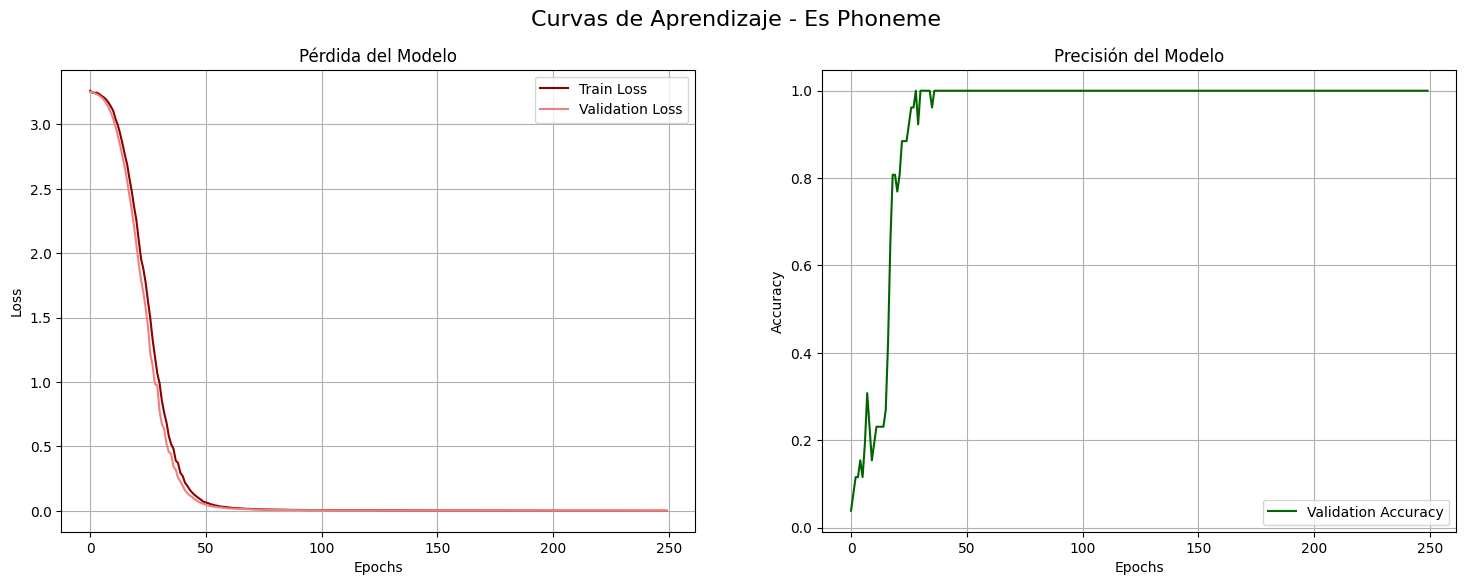

Reporte de clasificación guardado.


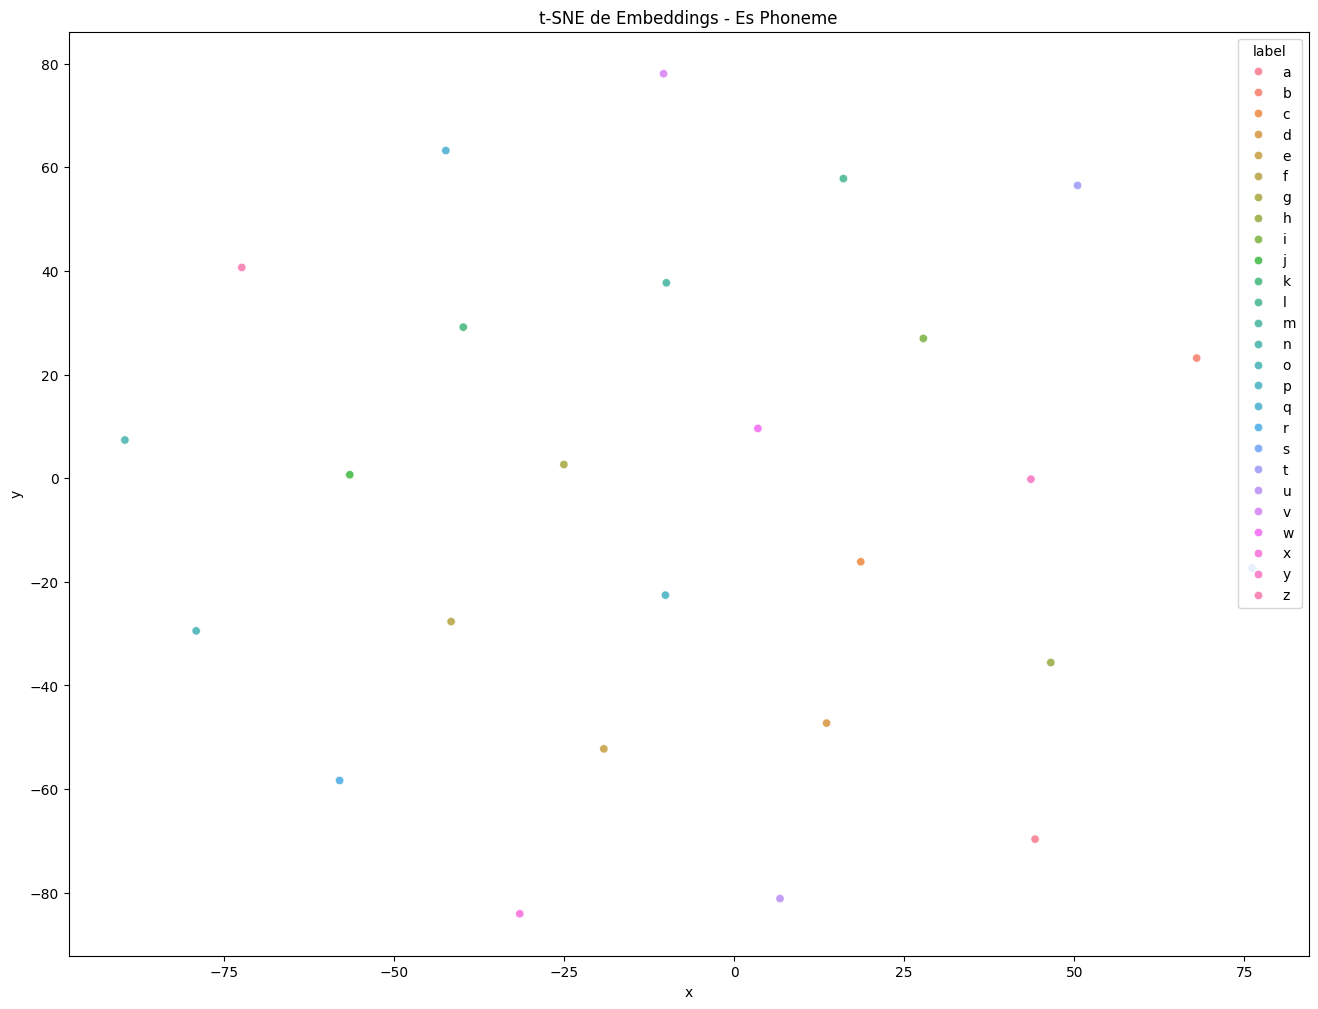

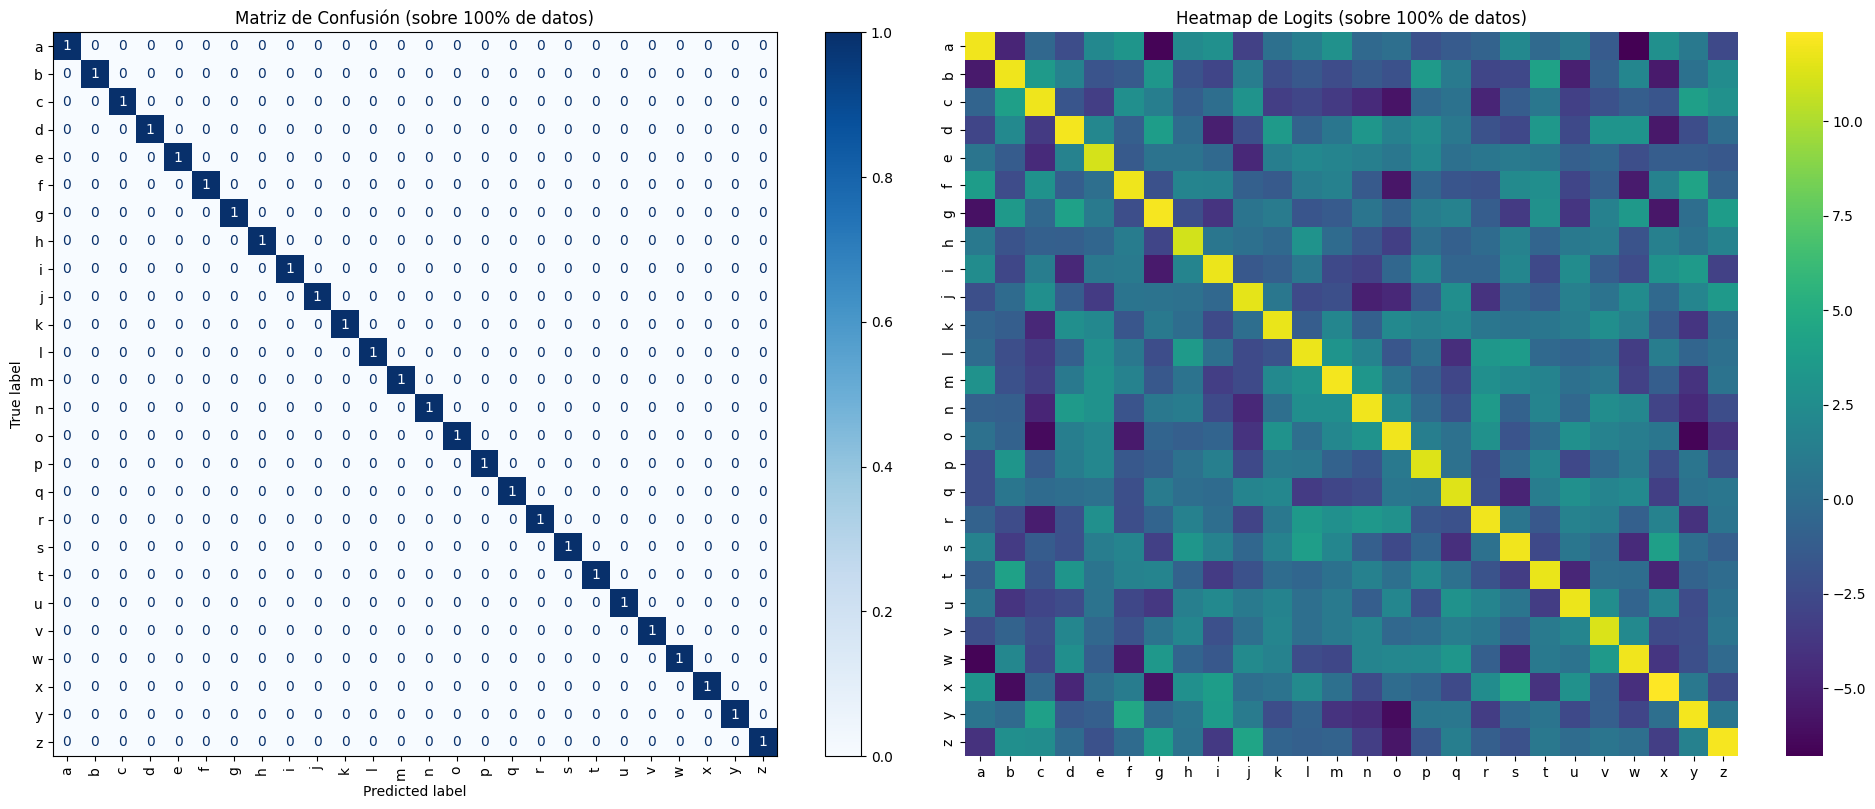

Modelo Experto y mapeo guardados en: /home/daniel/Proyectos/phonological-awareness/results/trained_models/es_phoneme_expert.pth


--- Generando artefactos para: Es Word ---


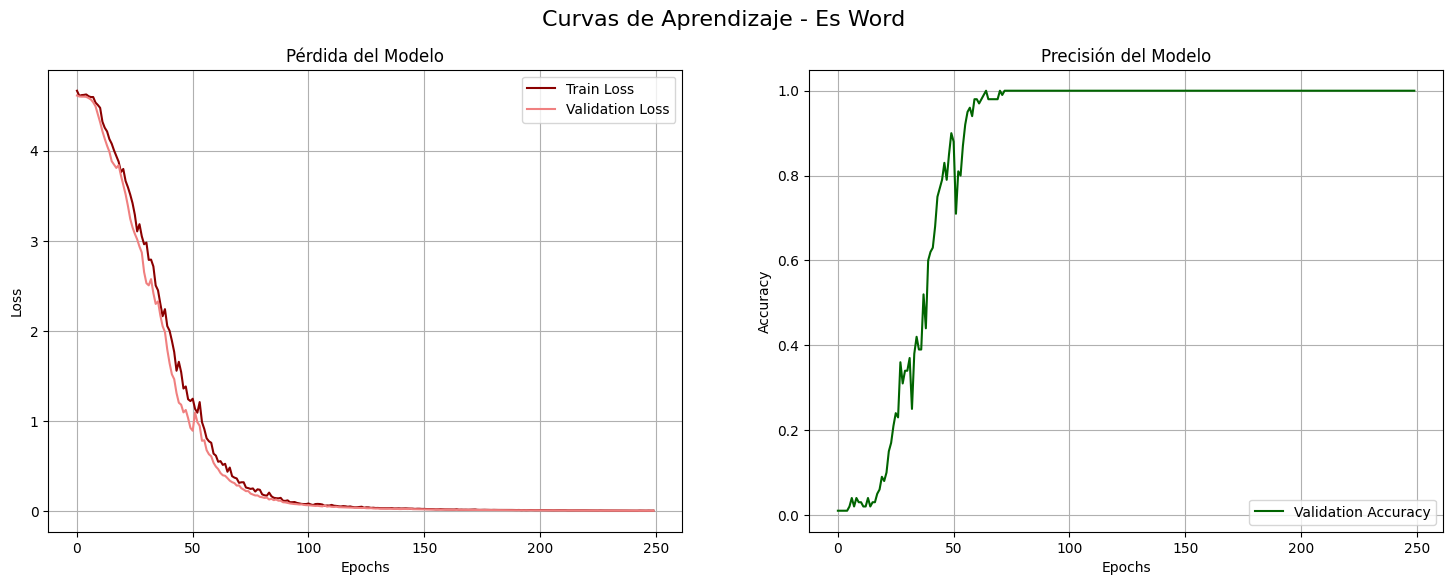

Reporte de clasificación guardado.


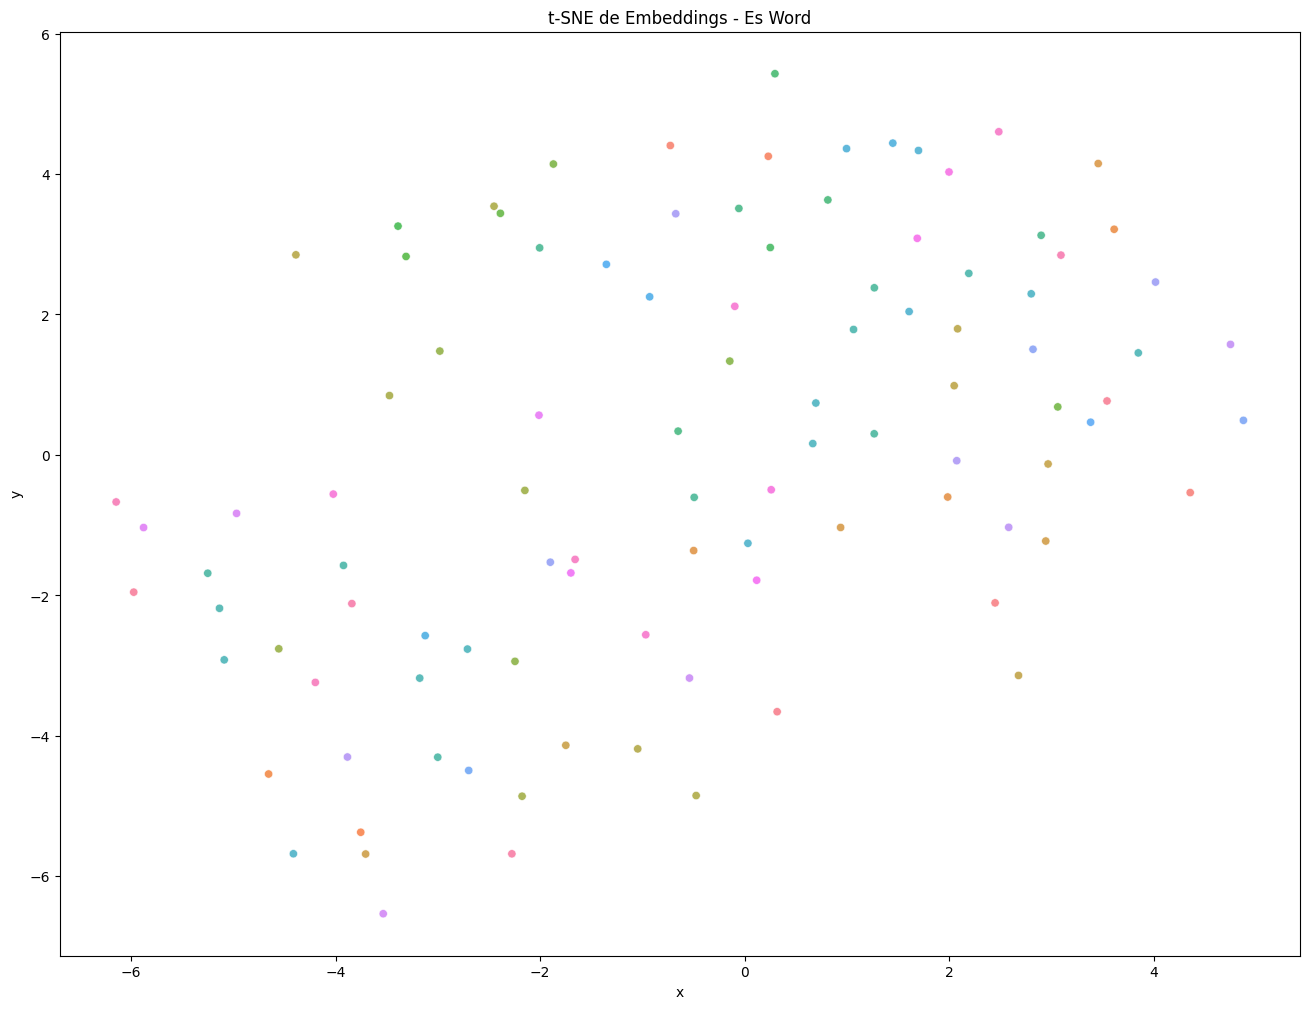

Modelo Experto y mapeo guardados en: /home/daniel/Proyectos/phonological-awareness/results/trained_models/es_word_expert.pth


--- Generando artefactos para: En Phoneme ---


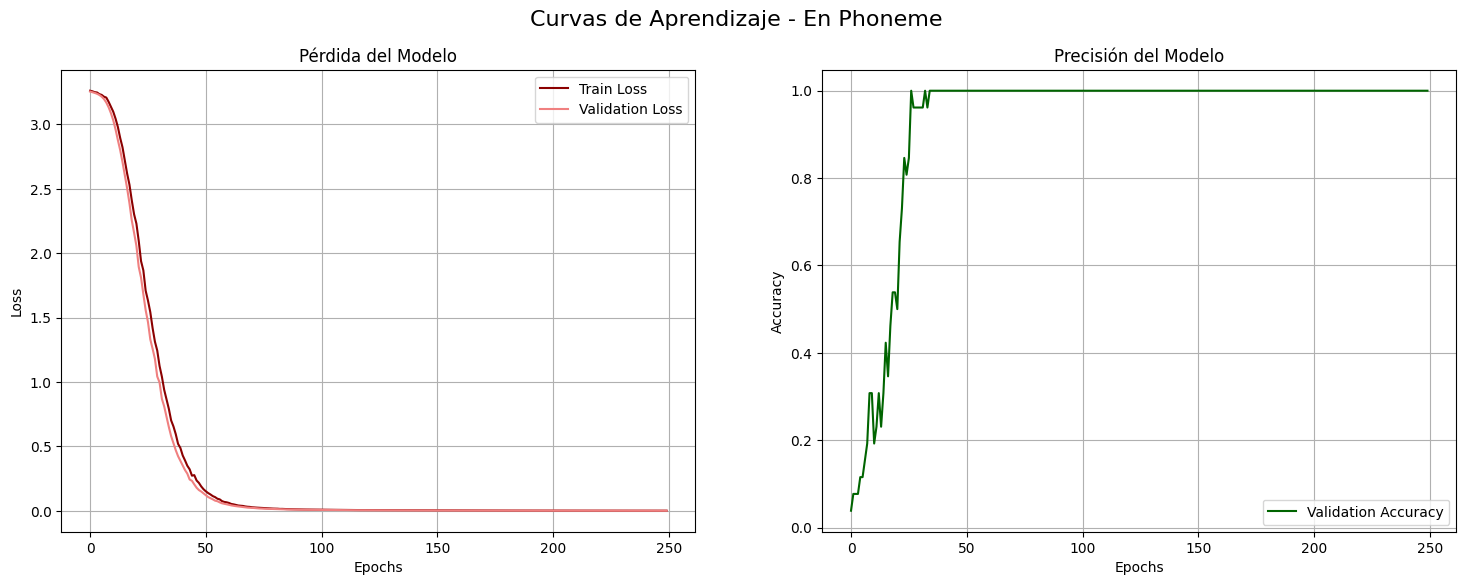

Reporte de clasificación guardado.


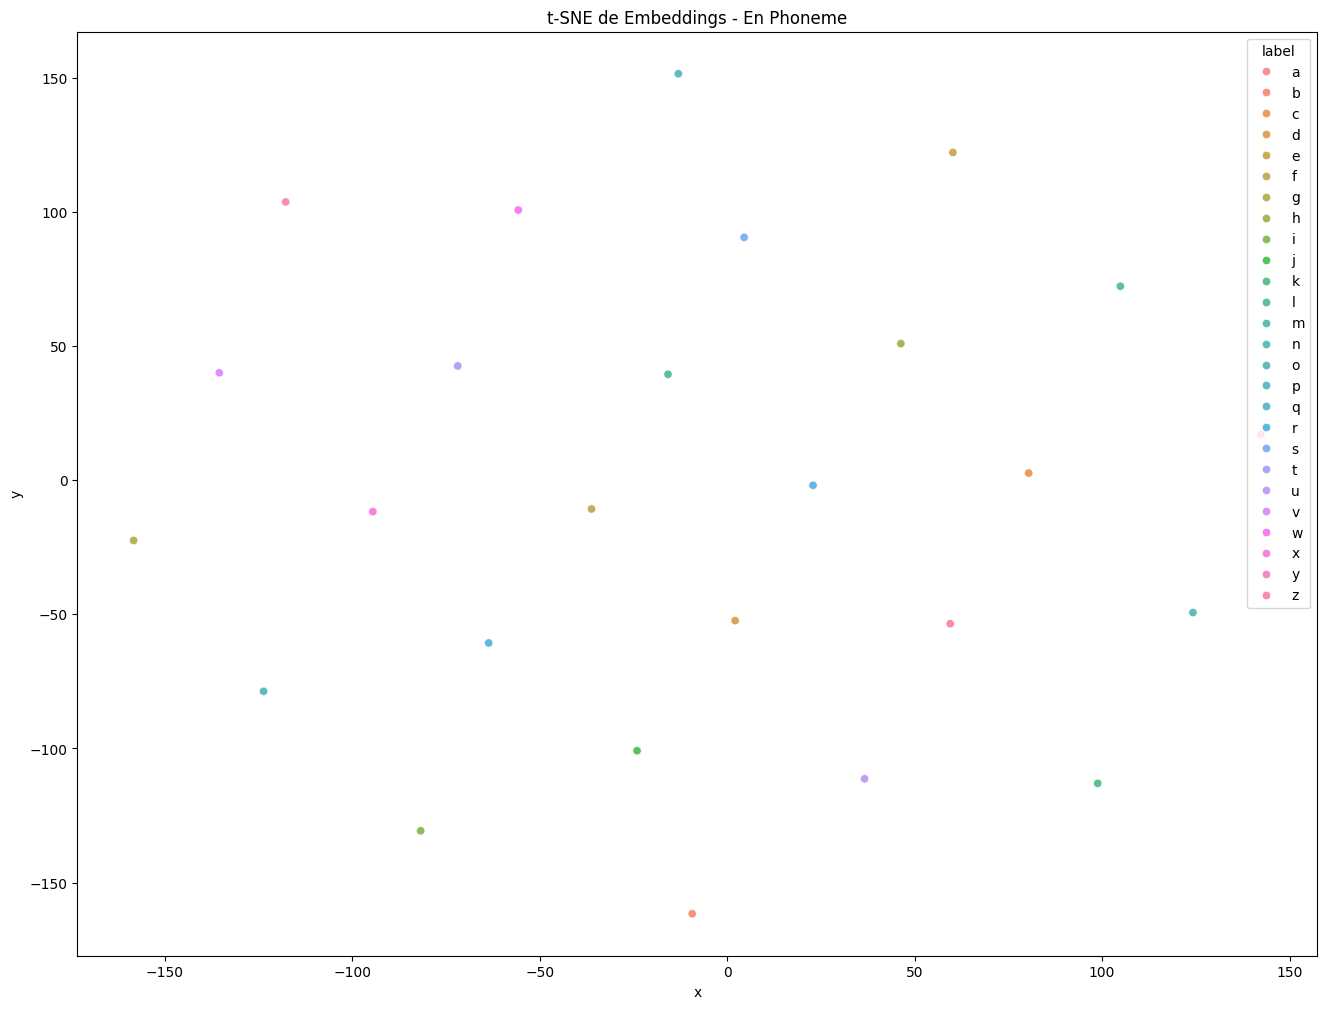

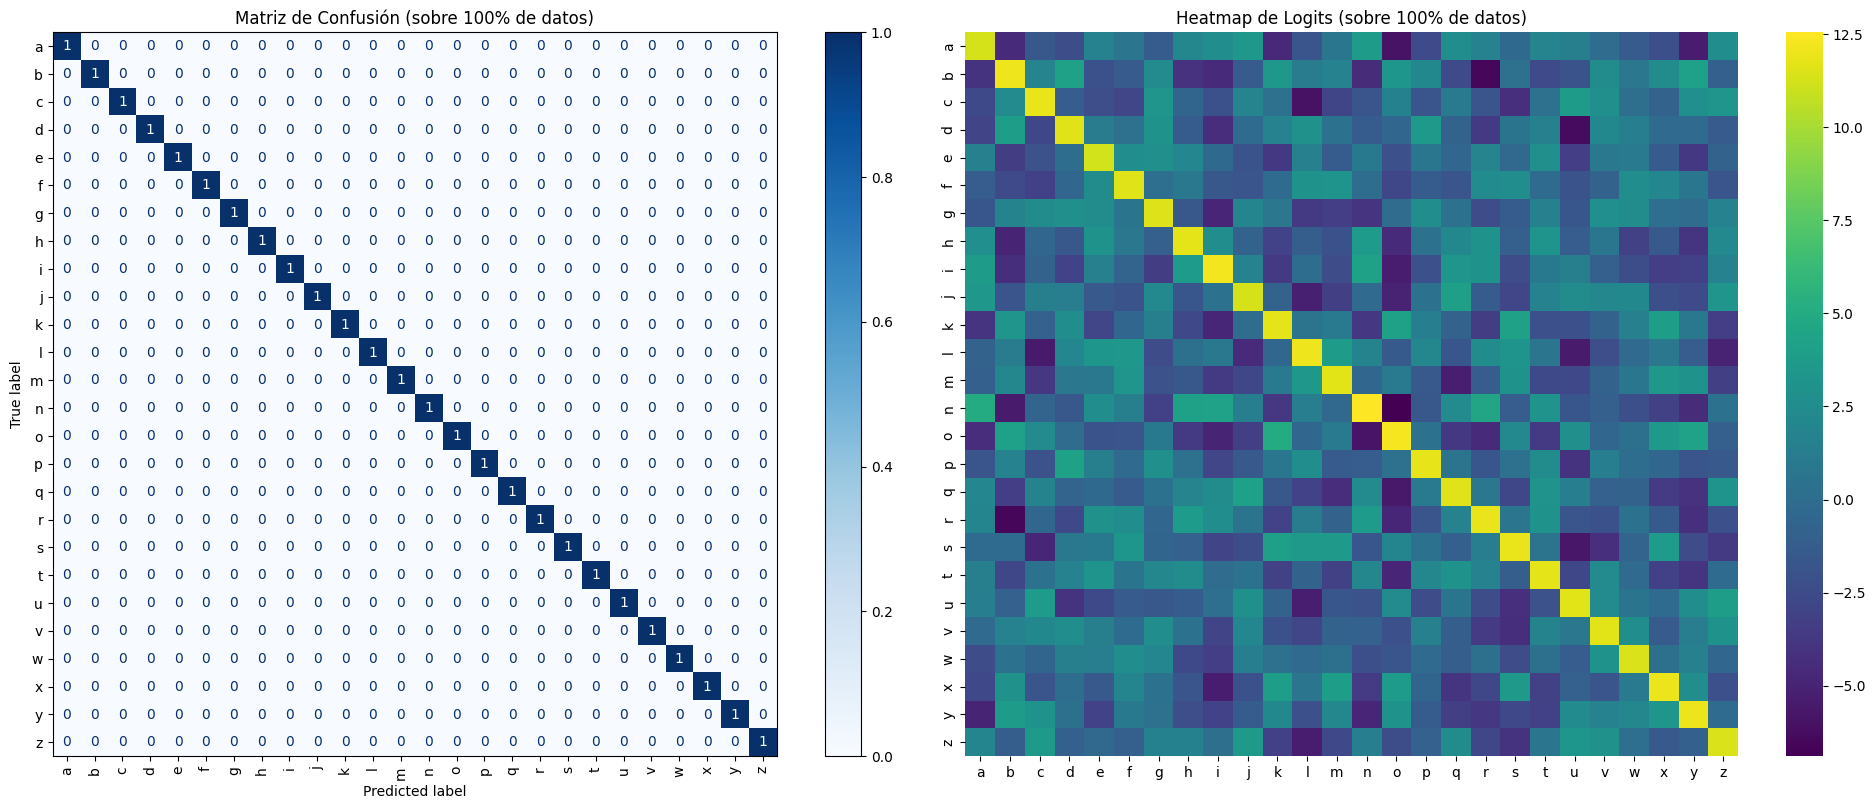

Modelo Experto y mapeo guardados en: /home/daniel/Proyectos/phonological-awareness/results/trained_models/en_phoneme_expert.pth


--- Generando artefactos para: En Word ---


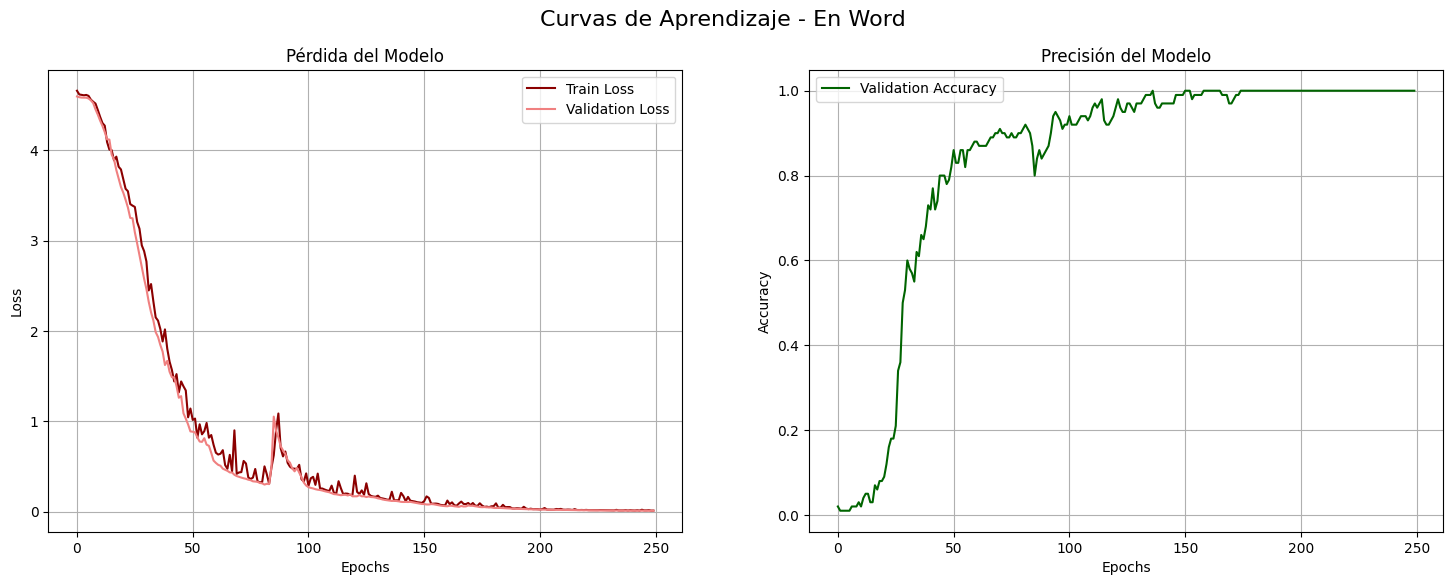

Reporte de clasificación guardado.


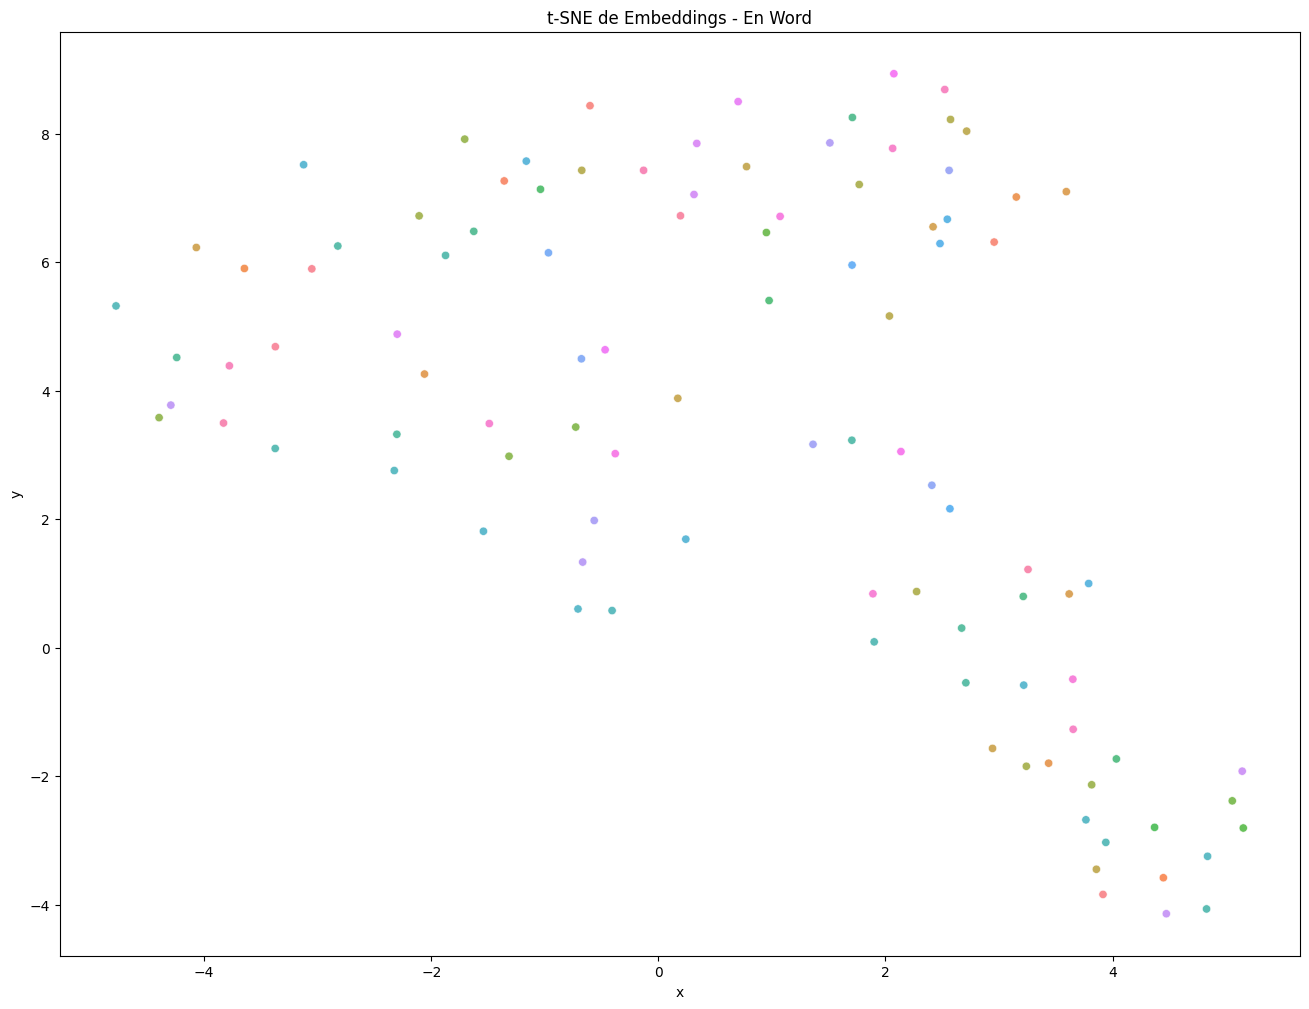

Modelo Experto y mapeo guardados en: /home/daniel/Proyectos/phonological-awareness/results/trained_models/en_word_expert.pth



In [5]:
# ===================================================================
# Celda 6: Bucle de Evaluación Final, Visualización y Guardado
# ===================================================================
for name, result in results_all.items():
    lang, expert_type = name.split('_')
    print(f"\n--- Generando artefactos para: {name.replace('_', ' ').title()} ---")
    
    model = result['model']; history = result['history']; dataset = result['dataset']
    
    # --- 1. Generar Curvas de Aprendizaje ---
    plot_learning_curves(history, f'Curvas de Aprendizaje - {name.replace("_", " ").title()}', figure_dir / f"{name}_learning_curves.png")

    # --- 2. Recolectar Predicciones y Embeddings del Modelo Final ---
    full_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_sequential)
    y_true, y_pred, logits_list, all_embeddings_mean = [], [], [], []
    model.eval()
    with torch.no_grad():
        for seqs, lengths, labels in full_loader:
            if seqs is None: continue
            outputs = model(seqs.to(device), lengths)
            y_true.extend(labels.numpy()); y_pred.extend(outputs.argmax(1).cpu().numpy())
            logits_list.append(outputs.cpu()); all_embeddings_mean.append(seqs.mean(dim=1).cpu())

    # --- 3. Generar y Guardar Reporte de Clasificación ---
    report = classification_report(y_true, y_pred, labels=range(len(dataset.labels_text)), target_names=dataset.labels_text, output_dict=True, zero_division=0)
    report_df = pd.DataFrame(report).transpose()
    report_df.to_csv(results_dir / f"{name}_classification_report.csv")
    print("Reporte de clasificación guardado.")

    # --- 4. Generar y Guardar t-SNE ---
    embeddings_for_tsne = torch.cat(all_embeddings_mean).numpy()
    labels_for_tsne = [dataset.int_to_label[i] for i in y_true]
    tsne = TSNE(n_components=2, random_state=RANDOM_SEED, perplexity=min(30, len(embeddings_for_tsne)-1))
    tsne_results = tsne.fit_transform(embeddings_for_tsne)
    df = pd.DataFrame({'x': tsne_results[:, 0], 'y': tsne_results[:, 1], 'label': labels_for_tsne})
    plt.figure(figsize=(16, 12)); sns.scatterplot(x='x', y='y', hue='label', data=df, alpha=0.8, legend='full' if expert_type == 'phoneme' else False)
    plt.title(f't-SNE de Embeddings - {name.replace("_", " ").title()}'); plt.savefig(figure_dir / f"{name}_tsne.png"); plt.show()

    # --- 5. Generar y Guardar Matriz de Confusión y Logits (SOLO PARA FONEMAS) ---
    if expert_type == "phoneme":
        fig, axes = plt.subplots(1, 2, figsize=(20, 8))
        cm = confusion_matrix(y_true, y_pred, labels=range(len(dataset.labels_text)))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.labels_text)
        axes[0].set_title("Matriz de Confusión (sobre 100% de datos)"); disp.plot(ax=axes[0], xticks_rotation='vertical', cmap='Blues')
        logits_df = pd.DataFrame(torch.cat(logits_list).numpy(), index=dataset.labels_text, columns=dataset.labels_text).sort_index()
        axes[1].set_title("Heatmap de Logits (sobre 100% de datos)"); sns.heatmap(logits_df, ax=axes[1], cmap='viridis')
        plt.tight_layout(); plt.savefig(figure_dir / f"{name}_confusion_logits.png"); plt.show()
    
    # --- 6. Guardar Modelo Final ---
    model_path = model_dir / f"{name}_expert.pth"
    torch.save({'model_state_dict': model.state_dict(), 'label_map': dataset.label_to_int}, model_path)
    print(f"Modelo Experto y mapeo guardados en: {model_path}\n")